Subspace alignment score: 0.0032


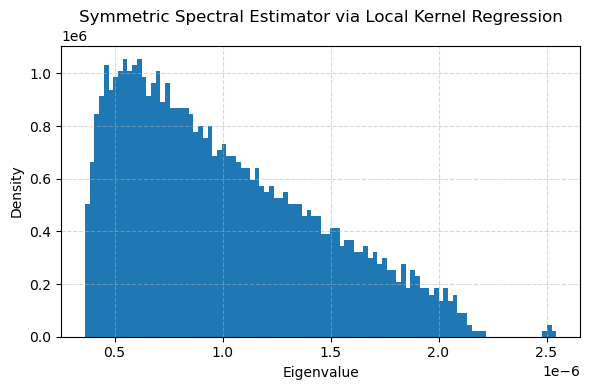

In [ ]:
import numpy as np
from numpy.linalg import eigh, norm
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Parameter settings
d = 1000              # Feature dimension
p = 2                 # Signal subspace dimension
alpha = 5             # Sampling ratio
n = int(alpha * d)    # Number of samples
k = 200               # Number of nearest neighbors (for local kernel estimation)
bandwidth = 0.1       # Bandwidth for RBF kernel

np.random.seed(42)

# Construct the true signal subspace
W_star = np.random.randn(d, p)
W_star, _ = np.linalg.qr(W_star)

# Generate samples X ∈ ℝ^{n×d}
X = np.random.randn(n, d) / np.sqrt(d)

# Project X onto the signal subspace: z = X @ W_star
Z = X @ W_star   # shape: (n, p)

# Link function g(z) = ||z||^2 / p
y = np.sum(Z**2, axis=1) / p

# Build nearest-neighbor graph + RBF kernel
nn = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(y.reshape(-1, 1))
distances, indices = nn.kneighbors(y.reshape(-1, 1))  # shape: (n, k)

# RBF kernel weights (each row corresponds to sample i)
weights = np.exp(-distances**2 / (2 * bandwidth**2))  # shape: (n, k)
weights /= np.sum(weights, axis=1, keepdims=True)

# Construct the symmetric spectral matrix
T_matrix = np.zeros((d * p, d * p))

for i in range(n):
    # Indices and kernel weights for the i-th sample
    idx = indices[i]        # shape: (k,)
    w = weights[i]          # shape: (k,)

    # Local kernel-weighted estimation of E[zzᵀ | yᵢ]
    Z_neighbors = Z[idx]                           # (k, p)
    outer_products = np.einsum('ki,kj->kij', Z_neighbors, Z_neighbors)  # (k, p, p)
    E_zzT = np.tensordot(w, outer_products, axes=([0], [0]))            # (p, p)

    # Compute xᵢ xᵢᵀ
    x_i = X[i]
    xxT = np.outer(x_i, x_i)  # (d, d)

    # Kronecker product update for T_matrix
    T_matrix += np.kron(xxT, E_zzT)

T_matrix /= n

# Eigen-decomposition of T_matrix
eigvals, eigvecs = eigh(T_matrix)
signal_vectors = eigvecs[:, -p:]  # Top-p eigenvectors

# Reshape estimated signal subspace to d × p
W_hat = np.zeros((d, p))
for j in range(p):
    W_hat[:, j] = signal_vectors[j*d:(j+1)*d, j]

# Subspace alignment score
def orthonormalize(mat):
    Q, _ = np.linalg.qr(mat)
    return Q

U_hat = orthonormalize(W_hat)
U_true = orthonormalize(W_star)
alignment_score = norm(U_true.T @ U_hat, 'fro')**2 / p
print(f"Subspace alignment score: {alignment_score:.4f}")

# Visualize eigenvalue density
plt.figure(figsize=(6, 4))
plt.hist(eigvals, bins=100, density=True)
plt.title("Symmetric Spectral Estimator via Local Kernel Regression")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


[KNN-SSE] Subspace alignment score: 0.0002


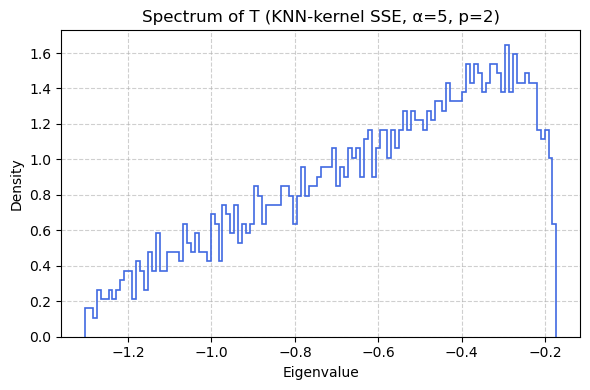

In [3]:
import numpy as np
from numpy.linalg import qr, svd
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# ================= 参数 =================
d = 1000
p = 2
alpha = 5
n = int(alpha * d)
k = 200              # KNN 邻居数
bandwidth = 0.1      # RBF 核带宽（作用在 y 的距离上）
ridge_eps = 1e-3     # T(y)=G(G+I)^-1 的岭正则
np.random.seed(42)

# ========== Step 1: 真值子空间 ==========
W_star = np.random.randn(d, p)
W_star, _ = qr(W_star)  # 列正交

# ========== Step 2: 生成数据 ==========
X = np.random.randn(n, d) / np.sqrt(d)
Z = X @ W_star
# 这里你试验的是 g(z)=||z||^2/p（与前面 z1*z2 不同）
y = np.sum(Z**2, axis=1) / p

# ========== Step 3: KNN + RBF 核，估计 Σ(y)=E[zz^T|y] ==========
nbrs = NearestNeighbors(n_neighbors=k).fit(y.reshape(-1, 1))
dist, idx = nbrs.kneighbors(y.reshape(-1, 1))        # (n,k)
w = np.exp(-dist**2 / (2 * bandwidth**2))            # (n,k)
w /= w.sum(axis=1, keepdims=True)

# 预存 z z^T（近邻需要）
Z_nn = Z[idx]                                        # (n,k,p)
# (n,k,2,2): 每个近邻样本的 zz^T
outer = Z_nn[..., :, None] * Z_nn[..., None, :]      # 广播得到外积

# Σ(y_i) = sum_j w_ij * (z_j z_j^T)
Sigma_y = (w[..., None, None] * outer).sum(axis=1)   # (n,2,2)

# ========== Step 4: G(y)=Σ-I,  T(y)=G(G+I)^-1 （加岭+solve）==========
I2 = np.eye(2)
G_y = Sigma_y - I2
T_y = np.empty_like(G_y)
for i in range(n):
    G = G_y[i]
    T_y[i] = G @ np.linalg.solve(G + (1.0 + ridge_eps) * I2, I2)

# ========== Step 5: 用块构造 T（高效替代 kron）==========
# T_(mu,nu) = X^T diag( T_y[:,mu,nu] ) X
blocks = [[None]*p for _ in range(p)]
for mu in range(p):
    for nu in range(p):
        wmu = T_y[:, mu, nu]            # (n,)
        blocks[mu][nu] = X.T @ (wmu[:, None] * X)    # (d,d)
T = np.block(blocks) / n
T = 0.5 * (T + T.T)                     # 数值对称化

# ========== Step 6: 取最大特征向量并 reshape 为 d×p ==========
eigval, eigvec = eigsh(T, k=1, which='LA')          # 最大特征值方向
W_hat = eigvec[:, 0].reshape(d, p)                  # 关键：reshape

# Procrustes 正交
U, _, Vt = svd(W_hat, full_matrices=False)
W_hat = U @ Vt

# ========== Step 7: 子空间对齐度 ==========
def orthonormalize(A):
    Q, _ = np.linalg.qr(A)
    return Q

U_hat = orthonormalize(W_hat)
U_true = orthonormalize(W_star)

s = svd(U_true.T @ U_hat, compute_uv=False)
alignment = (s**2).sum() / p
print(f"[KNN-SSE] Subspace alignment score: {alignment:.4f}")


# ========== Step 8: 谱密度图（线框风格） ==========
plt.figure(figsize=(6,4))
plt.hist(np.linalg.eigvalsh(T), bins=120, density=True,
         histtype="step", linewidth=1.2, color="royalblue")
plt.title(f"Spectrum of T (KNN-kernel SSE, α={alpha}, p={p})")
plt.xlabel("Eigenvalue"); plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()


Subspace alignment score: 0.0063


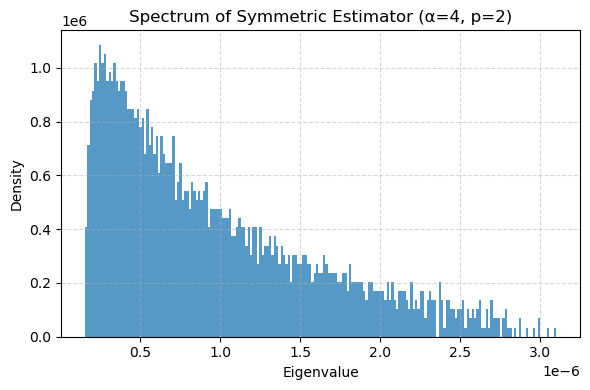

In [ ]:
import numpy as np
from numpy.linalg import qr, svd
from scipy.sparse.linalg import eigsh
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Parameter settings
d = 1000
p = 2
alpha = 5
n = int(alpha * d)
k = 200              # Number of nearest neighbors for KNN
bandwidth = 0.1      # RBF kernel bandwidth (applied on y-distances)
ridge_eps = 1e-3     # Ridge regularization for T(y) = G(G+I)^(-1)
np.random.seed(42)

# True signal subspace
W_star = np.random.randn(d, p)
W_star, _ = qr(W_star)  # Orthonormal columns

# Generate data
X = np.random.randn(n, d) / np.sqrt(d)
Z = X @ W_star
# Here we test g(z) = ||z||^2 / p (different from z₁·z₂ used earlier)
y = np.sum(Z**2, axis=1) / p

# KNN + RBF kernel to estimate Σ(y) = E[zzᵀ | y]
nbrs = NearestNeighbors(n_neighbors=k).fit(y.reshape(-1, 1))
dist, idx = nbrs.kneighbors(y.reshape(-1, 1))        # (n, k)
w = np.exp(-dist**2 / (2 * bandwidth**2))            # (n, k)
w /= w.sum(axis=1, keepdims=True)

# Precompute nearest neighbor z and outer products
Z_nn = Z[idx]                                        # (n, k, p)
outer = Z_nn[..., :, None] * Z_nn[..., None, :]      # (n, k, p, p)

# Σ(yᵢ) = Σ_j wᵢⱼ (zⱼ zⱼᵀ)
Sigma_y = (w[..., None, None] * outer).sum(axis=1)   # (n, p, p)

# Compute G(y) = Σ - I, and T(y) = G(G + I)^{-1} with ridge regularization
I2 = np.eye(2)
G_y = Sigma_y - I2
T_y = np.empty_like(G_y)
for i in range(n):
    G = G_y[i]
    T_y[i] = G @ np.linalg.solve(G + (1.0 + ridge_eps) * I2, I2)

# Construct block matrix T efficiently without explicit Kronecker products
# T_(μ,ν) = Xᵀ diag(T_y[:,μ,ν]) X
blocks = [[None]*p for _ in range(p)]
for mu in range(p):
    for nu in range(p):
        wmu = T_y[:, mu, nu]                         # (n,)
        blocks[mu][nu] = X.T @ (wmu[:, None] * X)    # (d, d)
T = np.block(blocks) / n
T = 0.5 * (T + T.T)                                 # Numerical symmetrization

# Extract leading eigenvector and reshape to d × p
eigval, eigvec = eigsh(T, k=1, which='LA')           # Top eigen-direction
W_hat = eigvec[:, 0].reshape(d, p)                   # Reshape to d×p

# Procrustes orthogonalization
U, _, Vt = svd(W_hat, full_matrices=False)
W_hat = U @ Vt

# Subspace alignment score
def orthonormalize(A):
    Q, _ = np.linalg.qr(A)
    return Q

U_hat = orthonormalize(W_hat)
U_true = orthonormalize(W_star)
s = svd(U_true.T @ U_hat, compute_uv=False)
alignment = (s**2).sum() / p
print(f"[KNN-SSE] Subspace alignment score: {alignment:.4f}")

# Eigenvalue density plot (line style)
plt.figure(figsize=(6, 4))
plt.hist(np.linalg.eigvalsh(T), bins=120, density=True,
         histtype="step", linewidth=1.2, color="royalblue")
plt.title(f"Spectrum of T (KNN-kernel SSE, α={alpha}, p={p})")
plt.xlabel("Eigenvalue")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
